#  imports

In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
import numpy as np 
import random 
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import seaborn as sns
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


#  loading the data

In [2]:
data_set= pd.read_csv("data.csv")
data_set_size =data_set.shape  
print(data_set_size )

(863, 15)


In [3]:
data_set.head(5)

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


#  divide the data into three partitions: training, and testing

In [4]:
labels = data_set['result']

# Drop the target column from the features
features = data_set.drop('result', axis=1)

In [5]:
#imbalanced data 
labels.value_counts()

0    755
1    108
Name: result, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
train_data_sets_size=y_train.shape[0]
print(len(X_test))

173


In [7]:
#show the count of values in training set 
#note : data is imbalanced 
y_train.value_counts()

0    607
1     83
Name: result, dtype: int64

# K-Nearest Neighbors

# IN OUR APPROCH WE CONSIDER THAT :
### - the most importance to us to minimize FN so highest recall is perfered as death (1) or recovered (0) : we see the some important to not to say recovered when the truth is that he/she will die so we cure about to minimizing false negatives so highest recall is preferred


###  using GridSearch to fine tuning the other parameters ,we use n_repeat =5 to deal with imbalance data


In [8]:
model = KNeighborsClassifier()
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
n_neighbors=[3,5,7,9,11]
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
knn_best_recall_params = grid_result.best_params_

Best: 0.599559 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [9]:
# Use the best hyperparameters found during grid search
best_knn_recall_model = KNeighborsClassifier(n_neighbors=knn_best_recall_params['n_neighbors'],
                                      weights=knn_best_recall_params['weights'],
                                      metric=knn_best_recall_params['metric'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

# Perform cross-validation for mean accuracy
cv_accuracy = cross_val_score(best_knn_recall_model, X_train, y_train, cv=cv, scoring='accuracy')

# Print mean accuracy and standard deviation
print("Mean Accuracy: %f" % cv_accuracy.mean())

Mean Accuracy: 0.933913


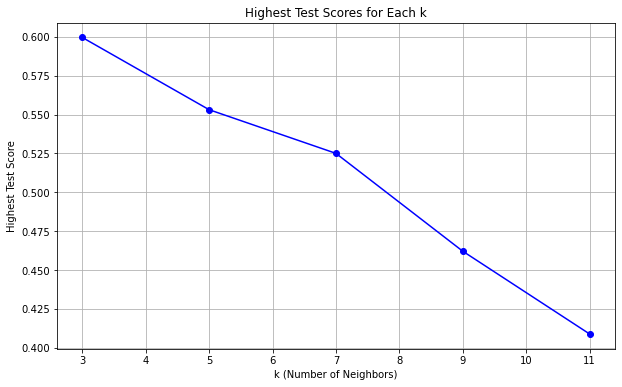

In [10]:
# Create a dictionary to store k values with their corresponding highest test scores
k_best_test_scores = {}

for mean, param in zip(means, params):
    k_value = param['n_neighbors']
    if k_value not in k_best_test_scores or mean > k_best_test_scores[k_value]:
        k_best_test_scores[k_value] = mean
        
# Extracting k values and corresponding highest test scores
k_values = list(k_best_test_scores.keys())
best_test_scores = list(k_best_test_scores.values())

# Creating a plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, best_test_scores, marker='o', linestyle='-', color='b')
plt.title('Highest Test Scores for Each k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Highest Test Score')
plt.grid(True)
plt.show()

In [11]:
model = KNeighborsClassifier()
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
n_neighbors=[3,5,7,9,11]
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
knn_best_accuracy_params = grid_result.best_params_

Best: 0.939420 using {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [12]:
# Use the best hyperparameters found during grid search
best_knn_accu_model = KNeighborsClassifier(n_neighbors=knn_best_accuracy_params['n_neighbors'],
                                      weights=knn_best_accuracy_params['weights'],
                                   metric=knn_best_accuracy_params['metric'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

# Perform cross-validation for mean accuracy
cv_accuracy = cross_val_score(best_knn_accu_model, X_train, y_train, cv=cv, scoring='recall')

# Print mean accuracy and standard deviation
print("Mean recall: %f" % cv_accuracy.mean())

Mean recall: 0.553088


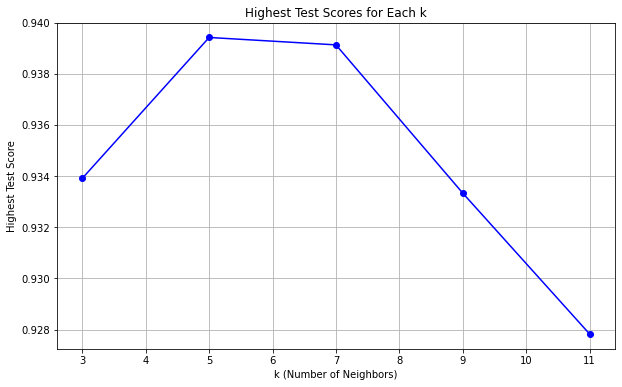

In [13]:
# Create a dictionary to store k values with their corresponding highest test scores
k_best_test_scores = {}

for mean, param in zip(means, params):
    k_value = param['n_neighbors']
    if k_value not in k_best_test_scores or mean > k_best_test_scores[k_value]:
        k_best_test_scores[k_value] = mean
        
# Extracting k values and corresponding highest test scores
k_values = list(k_best_test_scores.keys())
best_test_scores = list(k_best_test_scores.values())

# Creating a plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, best_test_scores, marker='o', linestyle='-', color='b')
plt.title('Highest Test Scores for Each k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Highest Test Score')
plt.grid(True)
plt.show()

## as best recall model is comparable with best accurate model we will use best recall model and we concern om the recall

# 2. Logistic Regression
## first fune tunning the hyperparameters of Logistic Regression model

In [14]:
# Create a Logistic Regression model
Logistic_Regression_model = LogisticRegression()

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [10000,20000],
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=Logistic_Regression_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(features, labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))



Best: 0.947395 using {'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}


## the best model with accuracy is the same the best model of recall

In [15]:
# Create a Logistic Regression model
Logistic_Regression_model = LogisticRegression()

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01],
    'max_iter': [10000,20000],
}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

grid_search = GridSearchCV(estimator=Logistic_Regression_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='recall', error_score=0)
grid_result = grid_search.fit(features, labels)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
LR_best_acc_params = grid_result.best_params_

Best: 0.722684 using {'C': 100, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'liblinear'}


# Naive Bayes classifier

In [16]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
grid_search = GridSearchCV(estimator=GaussianNB(), 
                     param_grid=params_NB, 
                     cv=cv,
                     verbose=1, 
                     scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 25 folds for each of 100 candidates, totalling 2500 fits
Best: 0.915072 using {'var_smoothing': 0.0004328761281083057}


## first get model with the highest accuracy we get recall so low

In [17]:
best_params_gb_acc = grid_result.best_params_
print(best_params_gb_acc)
Best_Accuracy_GB = GaussianNB(var_smoothing=best_params_gb_acc['var_smoothing'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

# Perform cross-validation for mean recall
cv_recall = cross_val_score(Best_Accuracy_GB, X_train, y_train, cv=cv, scoring='recall')
print("Mean Recall: %f" % cv_recall.mean())

{'var_smoothing': 0.0004328761281083057}
Mean Recall: 0.393529


## second get the best model in recall which we concern to compare

In [18]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1) 
grid_search = GridSearchCV(estimator=GaussianNB(), 
                     param_grid=params_NB, 
                     cv=cv,
                     verbose=1, 
                     scoring='recall')
grid_result =grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 25 folds for each of 100 candidates, totalling 2500 fits
Best: 0.890441 using {'var_smoothing': 1e-09}


In [19]:
best_params_gb_recall = grid_result.best_params_
print(best_params_gb_recall)
Best_Recall_GB = GaussianNB(var_smoothing=best_params_gb_recall['var_smoothing'])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)
# Perform cross-validation for mean accuracy
cv_recall = cross_val_score(Best_Recall_GB, X_train, y_train, cv=cv, scoring='accuracy')
print("Mean accuracy: %f" % cv_recall.mean())

{'var_smoothing': 1e-09}
Mean accuracy: 0.733043


## the recall of the best model on accuracy is so low so we choose the best model in recall

In [20]:
Models= {
    "KNN": KNeighborsClassifier(metric=knn_best_recall_params['metric'],
                                                    n_neighbors=knn_best_recall_params['n_neighbors'],
                                                    weights=knn_best_recall_params['weights']),
    "LR": LogisticRegression(solver=LR_best_acc_params['solver'],
                                                    penalty=LR_best_acc_params['penalty'],
                                                    C=LR_best_acc_params['C'],
                                                    max_iter=LR_best_acc_params['max_iter'])
,
    "GNB": GaussianNB(var_smoothing=best_params_gb_recall['var_smoothing'])}

# Now after fine tunning the models we will use test set to compare the different models
### 1- KNN has good overall accuracy and has best recall for class 1 but struggles with precision  for class 1.
### 2- LR performs well across all metrics, indicating robust classification with best f1-score  .
### 3- GNB shows good performance for class 0 but faces challenges with recall for class 1 with the worest accuracy  .


In [21]:
prediction = {}
for model_name, model in Models.items():
    fitted_model= model.fit(X_train, y_train)
    prediction[model_name]= fitted_model.predict(X_test)
    print(f"{model_name}: {round(model.score(X_test, y_test) * 100, 2)}%")
    print(classification_report(prediction[model_name],y_test))

KNN: 91.91%
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       158
           1       0.52      0.87      0.65        15

    accuracy                           0.92       173
   macro avg       0.75      0.90      0.80       173
weighted avg       0.95      0.92      0.93       173

LR: 93.64%
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       149
           1       0.76      0.79      0.78        24

    accuracy                           0.94       173
   macro avg       0.86      0.88      0.87       173
weighted avg       0.94      0.94      0.94       173

GNB: 75.72%
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       110
           1       0.92      0.37      0.52        63

    accuracy                           0.76       173
   macro avg       0.82      0.67      0.68       173
weighted avg       0.80      0.76      

### as we can see 2 FN in case of knn , 5  in case of logistic regression and 40 in case of gaussian naive classifier

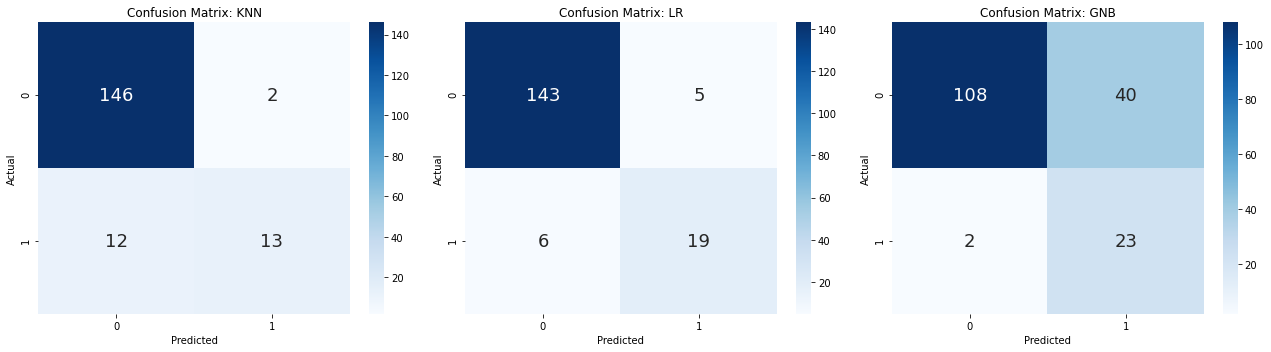

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) 

# Iterate over each (model_name, predicted_labels) pair and its corresponding subplot
for (model_name, predicted_labels), ax in zip(prediction.items(), axes):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, predicted_labels)
    
    # Create a heatmap using Seaborn
    sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt="d", cmap="Blues", ax=ax)
    
    # Set title and labels
    ax.set(title=f"Confusion Matrix: {model_name}", xlabel="Predicted", ylabel="Actual")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### Logistic Regression (LR) outperforms K-Nearest Neighbors (KNN) and Gaussian Naive Bayes (GNB) with the highest cross-validation score and a relatively low standard deviation , indicating stable and superior performance.

In [23]:
Model_df= pd.DataFrame(columns= ["Model", "Cross-val Score", "Standard Deviation"])
Cv = KFold(n_splits=10, shuffle=True, random_state=42)
for model_name, model in Models.items():
    Scores= cross_validate(model, X_train, y_train, cv= Cv, scoring="accuracy")["test_score"]
    Avg_acc= np.mean(Scores)
    Std_acc= np.std(Scores)
    
    Model_df= Model_df.append({"Model": model_name, "Cross-val Score": Avg_acc, "Standard Deviation": Std_acc}, ignore_index= True)

print(Model_df)

  Model  Cross-val Score  Standard Deviation
0   KNN         0.931884            0.037261
1    LR         0.949275            0.025311
2   GNB         0.768116            0.045830


### the best model is logistic regression as it has the largest area under the curve 

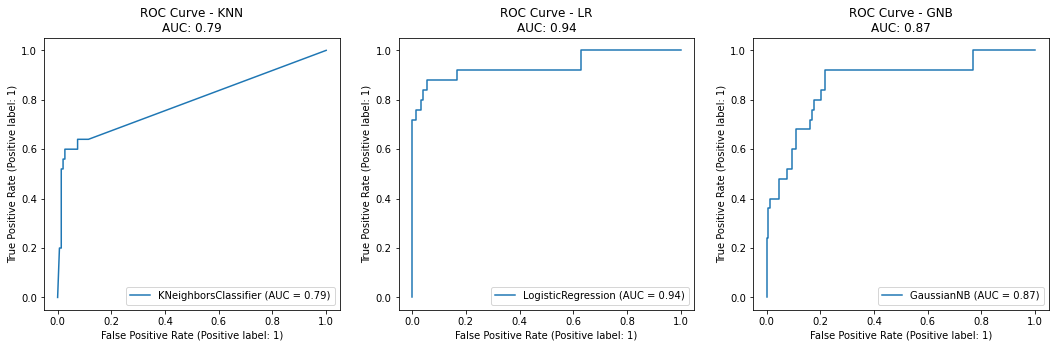

In [24]:

# Create a single figure for all models in the same row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Iterate over each model and its corresponding axis
for (model_name, model), ax in zip(Models.items(), axes):
    # Fit the model
    fitted_model = model.fit(X_train, y_train)

    # Plot the ROC curve
    plot_roc_curve(fitted_model, X_test, y_test, ax=ax)

    # Calculate the AUC score
    y_pred_proba = fitted_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Set the title with the AUC score
    ax.set_title(f"ROC Curve - {model_name}\nAUC: {auc_score:.2f}")

# Show the plots
plt.show()


### We attempted to employ various methods such as SMOTEENN, but it resulted in poorer performance. Additionally, normalizing the data caused the values to cluster closely in certain regions, thereby degrading the accuracy of our predictions.